# Practical PyTorch: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb)
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)

It would also be useful to know a bit about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`

In [1]:
import glob

filenames = glob.glob('../data/names/*.txt')
print(filenames)

['../data/names/Arabic.txt', '../data/names/Chinese.txt', '../data/names/Czech.txt', '../data/names/Dutch.txt', '../data/names/English.txt', '../data/names/French.txt', '../data/names/German.txt', '../data/names/Greek.txt', '../data/names/Irish.txt', '../data/names/Italian.txt', '../data/names/Japanese.txt', '../data/names/Korean.txt', '../data/names/Polish.txt', '../data/names/Portuguese.txt', '../data/names/Russian.txt', '../data/names/Scottish.txt', '../data/names/Spanish.txt', '../data/names/Vietnamese.txt']


In [2]:
import unicodedata

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def stripAccents(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

print(stripAccents('Ślusàrski'))

Slusarski


In [3]:
# Read a file and split into lines
def readNames(filename):
    names = open(filename).read().strip().split('\n')
    return [stripAccents(name) for name in names]

print(filenames[0], readNames(filenames[0])[:5])

../data/names/Arabic.txt ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


In [4]:
# Build the lang_names dictionary, a list of names per language
lang_names = {}
all_langs = []

for filename in filenames:
    lang = filename.split('/')[-1].split('.')[0]
    all_langs.append(lang)
    names = readNames(filename)
    lang_names[lang] = names

n_langs = len(all_langs)

Now we have `lang_names`, a dictionary mapping each language to a list of names. We also kept track of `all_langs` (just a list of languages) and `n_langs` for later reference.

In [5]:
print(lang_names['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<name_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [6]:
import torch
import string

all_letters = string.ascii_letters
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a name into a <name_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [7]:
print(letterToTensor('J'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0
[torch.FloatTensor of size 1x52]



In [8]:
print(nameToTensor('Jones').size())

torch.Size([5, 1, 52])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/oinm9ln.png)

In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        data = torch.cat((input, hidden), 1)
        hidden = self.i2h(data)
        output = self.i2o(data)
        output = self.softmax(output)
        return output, hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_langs)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [10]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `nameToTensor` instead of `letterToTensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [11]:
input = Variable(nameToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9287 -2.9427 -2.8622 -2.8814 -3.0286 -2.9597 -2.8905 -2.9284 -2.7817 -2.8260

Columns 10 to 17 
-2.7812 -2.8558 -2.9321 -2.9517 -2.9065 -2.9438 -2.8470 -2.8163
[torch.FloatTensor of size 1x18]



As you can see the output is a `<1 x n_classes>` Tensor, where every item is the likelihood of that class (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of every class. We can use `Tensor.topk` to get the index of the greatest value:

In [12]:
def classFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    class_i = top_i[0][0]
    return all_langs[class_i], class_i

print(classFromOutput(output))

('Japanese', 10)


We will also want a quick way to get a training example (a name and its language):

In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    lang = randomChoice(all_langs)
    name = randomChoice(lang_names[lang])
    return lang, name

for i in range(10):
    lang, name = randomTrainingPair()
    print('lang =', lang, '/ name =', name)

lang = Portuguese / name = Gouveia
lang = Dutch / name = Lyon
lang = Polish / name = Sobol
lang = Korean / name = Park 
lang = Scottish / name = Ritchie
lang = Arabic / name = Asker
lang = Spanish / name = Gomez
lang = Italian / name = Alesi
lang = Scottish / name = Walker
lang = Italian / name = Arnoni


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [14]:
criterion = nn.NLLLoss()

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [15]:
def train(target_lang, input_name):
    input = Variable(nameToTensor(input_name))
    target = Variable(torch.LongTensor([all_langs.index(target_lang)]))
    hidden = Variable(torch.zeros(1, n_hidden))

    rnn.zero_grad()

    for i in range(len(input_name)):
        output, hidden = rnn(input[i], hidden)

    loss = criterion(output, target)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-0.005, p.grad.data)

    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [16]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

rnn = RNN(n_letters, n_hidden, n_langs)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for epoch in range(1, n_epochs):
    target_lang, input_name = randomTrainingPair()
    output, loss = train(target_lang, input_name)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = classFromOutput(output)
        correct = '✓' if guess == target_lang else '✗ (%s)' % target_lang
        print('%d (%.2f) %s / %s %s' % (epoch, current_loss, input_name, guess, correct))
    
    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 (2602.65) Poletti / Polish ✗ (Italian)
10000 (2216.47) Gu / Vietnamese ✗ (Korean)
15000 (2042.95) Bonhomme / Polish ✗ (French)
20000 (1895.40) Crook / Scottish ✗ (English)
25000 (1784.32) Seif / Korean ✗ (Arabic)
30000 (1749.08) Gutteridge / Irish ✗ (English)
35000 (1571.16) Golovach / Dutch ✗ (Russian)
40000 (1535.68) Cao / Vietnamese ✓
45000 (1509.41) Rousseau / French ✓
50000 (1581.49) Brose / Scottish ✗ (German)
55000 (1483.82) Kerner / German ✓
60000 (1423.75) Kwang  / Korean ✓
65000 (1444.98) Filipowski / Polish ✓
70000 (1377.12) Kolbe / Dutch ✗ (German)
75000 (1393.07) Ramires / Portuguese ✓
80000 (1340.71) Giles / Portuguese ✗ (French)
85000 (1356.88) Moulin / Irish ✗ (French)
90000 (1390.55) Vo / Vietnamese ✓
95000 (1327.30) Hass / English ✗ (German)


# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

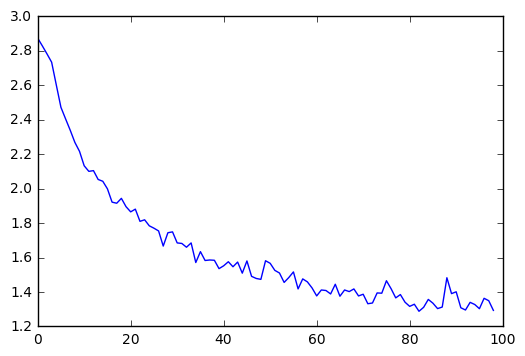

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

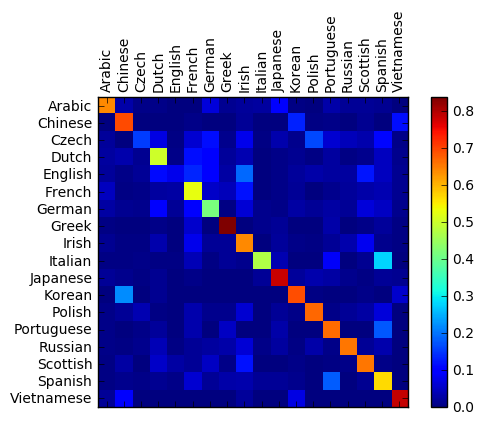

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_langs, n_langs)
n_confusion = 10000

# Just return an output given a name
def evaluate(input_name):
    input = Variable(nameToTensor(input_name))
    hidden = Variable(torch.zeros(1, n_hidden))
    
    for i in range(len(input_name)):
        output, hidden = rnn(input[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    target_lang, input_name = randomTrainingPair()
    output = evaluate(input_name)
    guess, guess_i = classFromOutput(output)
    lang_i = all_langs.index(target_lang)
    confusion[lang_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_langs):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_langs, rotation=90)
ax.set_yticklabels([''] + all_langs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [19]:
def predict(input_name, n_predictions=3):
    print('\n> %s' % input_name)
    output = evaluate(input_name)

    # Get top N languages
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        lang_index = topi[0][i]
        print('(%.2f) %s' % (value, all_langs[lang_index]))
        predictions.append([value, all_langs[lang_index]])

predict('Dovesky')
predict('Jackson')


> Dovesky
(-0.90) Russian
(-1.32) Polish
(-1.86) Czech

> Jackson
(-0.23) Scottish
(-2.39) English
(-3.40) Russian


The final versions of the scripts [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch) split the above code into a few files:

* `data.py` (loads files)
* `model.py` (defines the RNN)
* `train.py` (runs training)
* `predict.py` (runs `predict()` with command line arguments)
* `server.py` (serve prediction as a JSON API with bottle.py)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions: 

```
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit http://localhost:5533/Yourname to get JSON output of predictions.